# JMOD Preprocessing — Python (QuantQC)

Reproduces `R/Preproc.R` step-for-step using the Python `quantqc` package.

In [78]:
import sys, os, re
sys.path.insert(0, os.path.expanduser('~/Desktop/Github/QuantQC/python'))

import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
%matplotlib inline

import quantqc as qqc
from quantqc.core import mat_to_df, df_to_mat

---
## 1. Make linker

Extract well from file names in the raw parquet and write `linker_jmod.csv`.
The `plate` column must be added manually (= 1 here).

In [79]:

# ── UPDATE path_raw to where you keep the raw parquet ──
path_raw  = '/Users/andrewleduc/Desktop/jmod_raw/'
# All other paths are relative to this notebook's location (Python/)
path_meta = os.path.normpath(os.path.join(os.getcwd(), '../meta_data')) + '/'
data_out  = os.path.normpath(os.path.join(os.getcwd(), '../data_out_temp')) + '/'

os.makedirs(data_out, exist_ok=True)
'''
raw_df = pq.read_table(os.path.join(path_raw, 'JModPlate1Slide2.parquet'),
                        columns=['file_name']).to_pandas()

raw_df['Well'] = raw_df['file_name'].str.extract(r'(?<=_)([^_/]+)(?=\.mzML$)')

linker = raw_df.drop_duplicates(subset='file_name')[['file_name', 'Well']].copy()
linker = linker.rename(columns={'file_name': 'Run'})
linker['plate'] = 1

linker_path = os.path.join(path_meta, 'linker_jmod.csv')
linker.to_csv(linker_path, index=False)
print(f'Linker saved: {linker.shape[0]} runs → {linker_path}')'''

"\nraw_df = pq.read_table(os.path.join(path_raw, 'JModPlate1Slide2.parquet'),\n                        columns=['file_name']).to_pandas()\n\nraw_df['Well'] = raw_df['file_name'].str.extract(r'(?<=_)([^_/]+)(?=\\.mzML$)')\n\nlinker = raw_df.drop_duplicates(subset='file_name')[['file_name', 'Well']].copy()\nlinker = linker.rename(columns={'file_name': 'Run'})\nlinker['plate'] = 1\n\nlinker_path = os.path.join(path_meta, 'linker_jmod.csv')\nlinker.to_csv(linker_path, index=False)\nprint(f'Linker saved: {linker.shape[0]} runs → {linker_path}')"

---
## 2. Set paths

In [80]:
data_path   = os.path.join(path_raw,  'JModPlate1Slide2.parquet')
linker_path = os.path.join(path_meta, 'linker_jmod.csv')

all_cells = {
    'mouse1': os.path.join(path_meta, 'sample_1_try2_isolated.xls'),
    'mouse2': os.path.join(path_meta, 'sample_2_isolated.xls'),
}

---
## 3. Import JMOD data and build miceotope matrices

In [81]:
r1 = qqc.jmod_to_qqc(data_path, linker_path, plex=3, carrier=False)
print(f'Raw data shape: {r1.raw_data.shape}')

Raw data shape: (2152522, 17)


In [82]:
r1 = qqc.miceotope_cell_x_peptide_jmod(r1, ch_q_val=1, t=5)
print(f'Peptide matrix:  {r1.matrices.peptide.shape[0]} peptides x {r1.matrices.peptide.shape[1]} cells')
print(f'Miceotope Raw_H: {r1.miceotopes.Raw_H.shape[0]} peptides x {r1.miceotopes.Raw_H.shape[1]} cells')

Peptide matrix:  13226 peptides x 282 cells
Miceotope Raw_H: 6208 peptides x 282 cells


/Users/andrewleduc/anaconda3/envs/scp/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1216: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a, func=_nanmedian, keepdims=keepdims,


---
## 4. Link CellenONE metadata

In [83]:
r1 = qqc.link_cellenone_raw(r1, all_cells)
r1.meta_data.head(10)

,ID,diameter,sample,label,injectWell,plate,prot_total,Run,Well,plate_linker,Order
0,E171.0,32.35,mouse2,0,E17,1.0,31.267007,/Volumes/Lab/KMD/Data/MouseDataJMod/MousePlate...,E17,1.0,57.0
1,E171.4,37.55,mouse1,4,E17,1.0,31.683464,/Volumes/Lab/KMD/Data/MouseDataJMod/MousePlate...,E17,1.0,57.0
2,E171.8,26.78,mouse2,8,E17,1.0,27.035569,/Volumes/Lab/KMD/Data/MouseDataJMod/MousePlate...,E17,1.0,57.0
3,E181.0,41.23,mouse1,0,E18,1.0,32.842982,/Volumes/Lab/KMD/Data/MouseDataJMod/MousePlate...,E18,1.0,58.0
4,E181.4,25.42,mouse2,4,E18,1.0,30.937897,/Volumes/Lab/KMD/Data/MouseDataJMod/MousePlate...,E18,1.0,58.0
5,E181.8,33.14,mouse2,8,E18,1.0,31.518991,/Volumes/Lab/KMD/Data/MouseDataJMod/MousePlate...,E18,1.0,58.0
6,E191.0,28.81,mouse2,0,E19,1.0,31.698994,/Volumes/Lab/KMD/Data/MouseDataJMod/MousePlate...,E19,1.0,59.0
7,E191.4,26.39,mouse2,4,E19,1.0,32.035976,/Volumes/Lab/KMD/Data/MouseDataJMod/MousePlate...,E19,1.0,59.0
8,E191.8,34.09,mouse1,8,E19,1.0,31.923764,/Volumes/Lab/KMD/Data/MouseDataJMod/MousePlate...,E19,1.0,59.0
9,E201.0,34.34,mouse2,0,E20,1.0,30.988270,/Volumes/Lab/KMD/Data/MouseDataJMod/MousePlate...,E20,1.0,60.0


---
## 5. Slide layout visualization

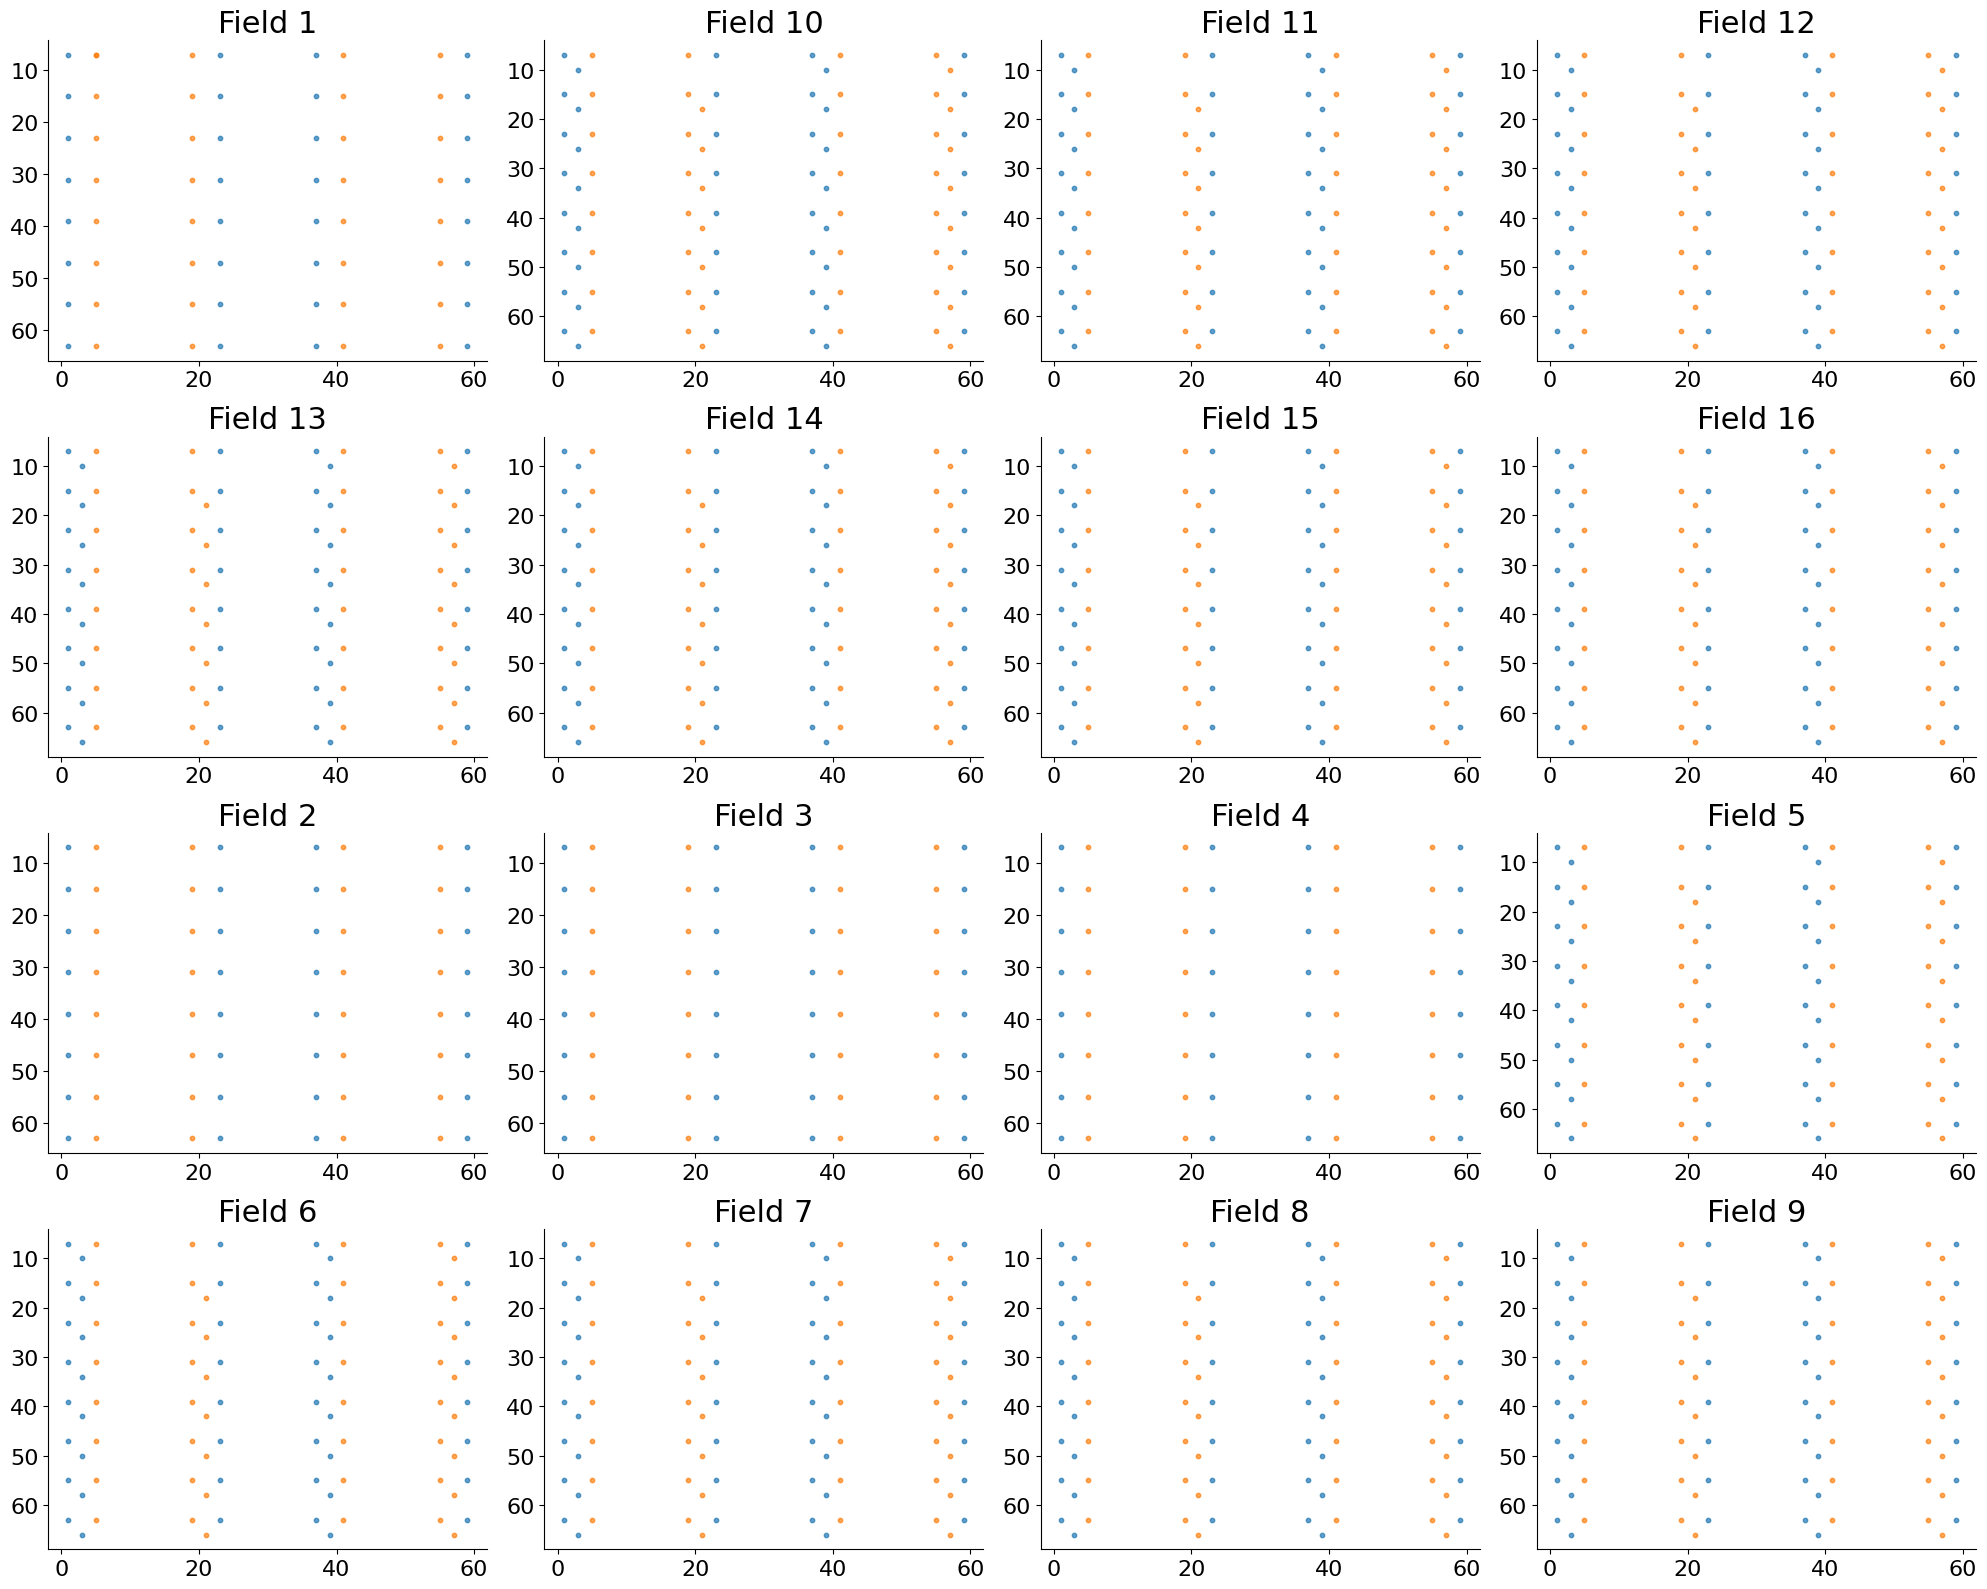

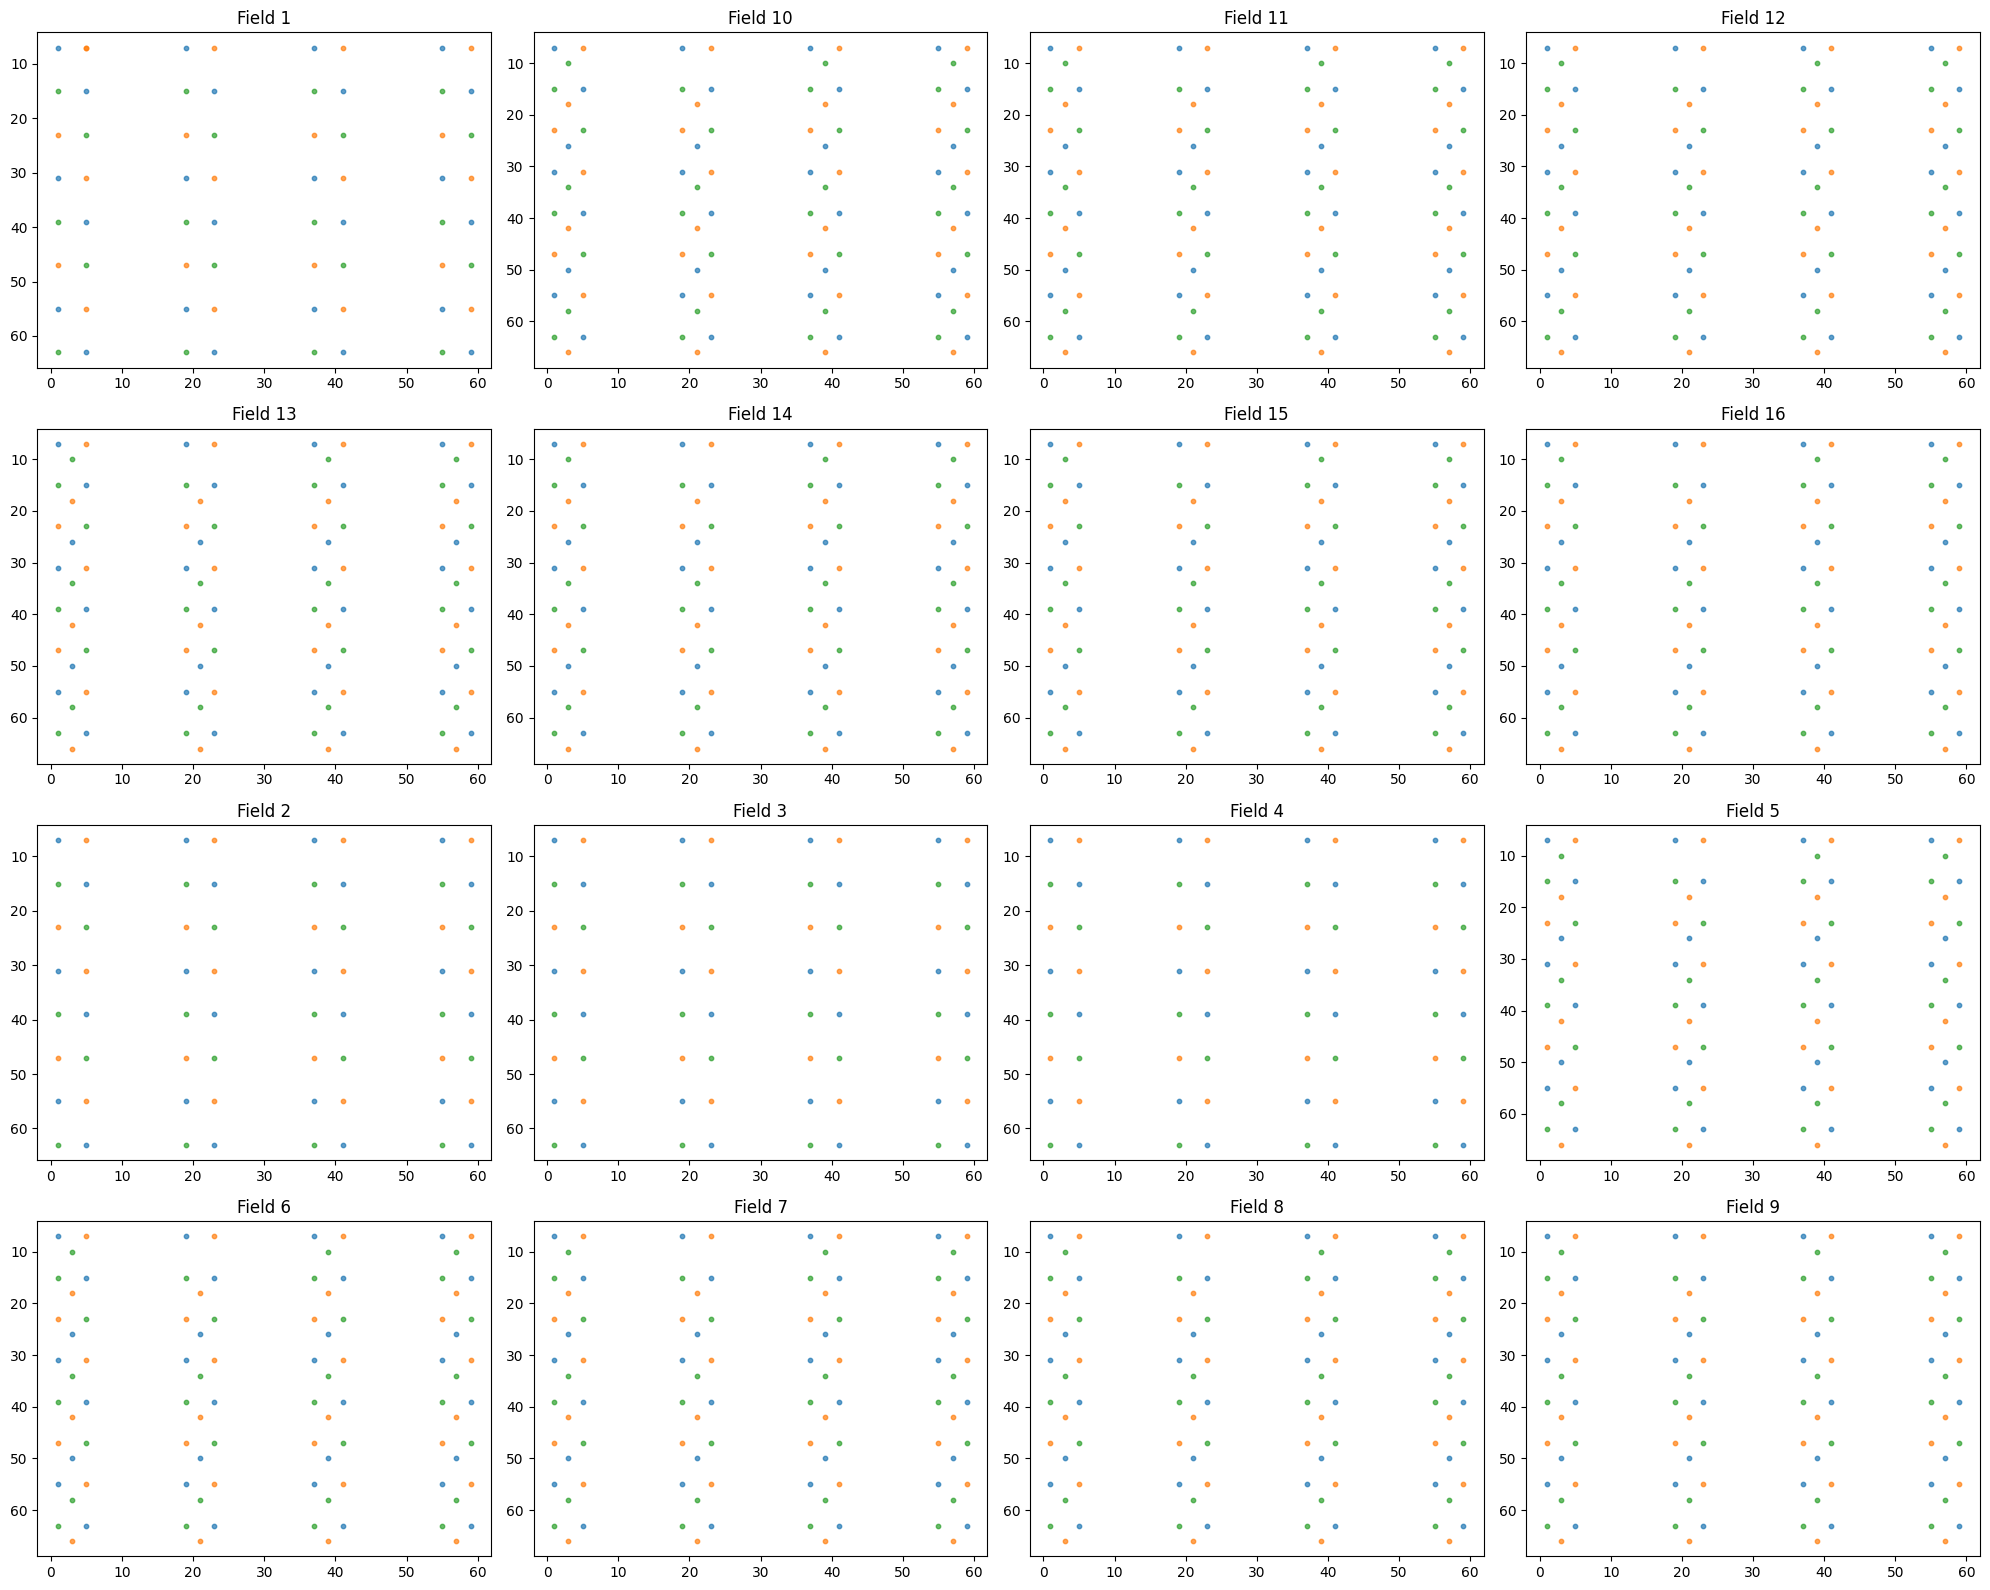

In [84]:
from quantqc.cellenone import plot_slide_layout_celltype, plot_slide_layout_label

fig = plot_slide_layout_celltype(r1)
plt.show()

fig = plot_slide_layout_label(r1)
plt.show()

---
## 6. Evaluate negative controls and filter bad cells

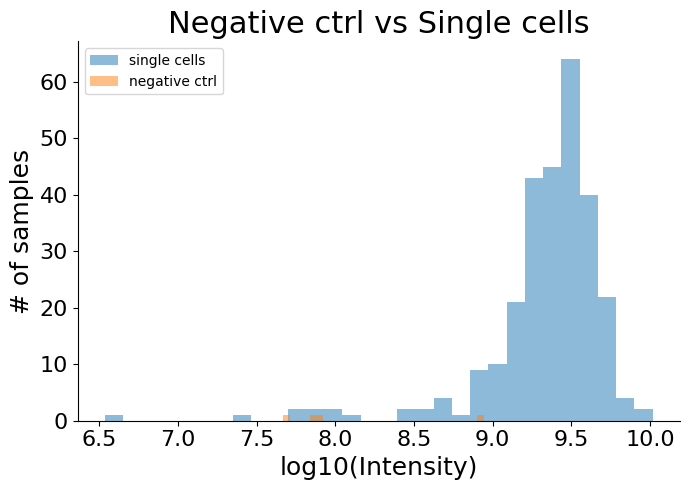

In [85]:
r1 = qqc.evaluate_negative_controls(r1)

fig = qqc.plot_neg_ctrl(r1)
plt.show()

In [86]:
print(f'Cells before filtering: {r1.matrices.peptide.shape[1]}')
r1 = qqc.filter_bad_cells(r1, min_intens=9)
print(f'Cells after filtering:  {r1.matrices.peptide.shape[1]}')

Cells before filtering: 282
Cells after filtering:  250


---
## 7. Trim extra peptides

Keep at most 5 best peptides per protein.

In [87]:
print(f'Peptides before trim: {r1.matrices.peptide.shape[0]}')
r1 = qqc.trim_extra_peptides(r1)
print(f'Peptides after trim:  {r1.matrices.peptide.shape[0]}')

Peptides before trim: 13226


/Users/andrewleduc/Desktop/Github/QuantQC/python/quantqc/filtering.py:208: RuntimeWarning: All-NaN slice encountered
  medians = np.nanmedian(sub, axis=1)


Peptides after trim:  6424


In [88]:
print(f'Miceotope H peptides before trim: {r1.miceotopes.Raw_H.shape[0]}')
r1 = qqc.trim_extra_peptides_miceotopes(r1)
print(f'Miceotope H peptides after trim:  {r1.miceotopes.Raw_H.shape[0]}')

Miceotope H peptides before trim: 6208
Miceotope H peptides after trim:  6208


---
## 8. Cell size vs MS intensity

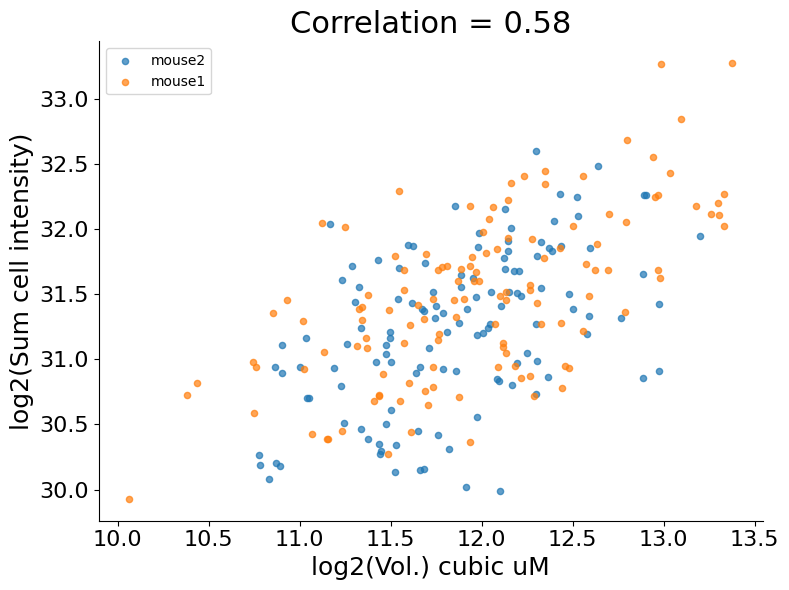

In [89]:
fig = qqc.plot_cell_size_vs_intensity(r1, type_='sample')
plt.show()

---
## 9. Normalize and collapse to protein level

Set `ms_type = 'DDA'` before collapsing so the DDA normalization path is used
(mirrors `r1@ms_type <- 'miceotopes'` → `CollapseToProtein` in R, which uses the
same median-of-normalized-peptides path, not the DIA mask path).

In [ ]:
r1.ms_type = 'miceotopes'
r1 = qqc.collapse_to_protein(r1, opt=1, lc_correct=True)
print(f'Protein matrix: {r1.matrices.protein.shape[0]} proteins x {r1.matrices.protein.shape[1]} cells')



/Users/andrewleduc/Desktop/Github/QuantQC/python/quantqc/utils.py:48: RuntimeWarning: All-NaN slice encountered
  ref_vec = np.nanmedian(dat, axis=1)
/Users/andrewleduc/Desktop/Github/QuantQC/python/quantqc/utils.py:55: RuntimeWarning: Mean of empty slice
  m = np.nanmean(row)


Protein matrix: 1954 proteins x 250 cells


In [91]:
# Visualize LC run-order drift corrections
# global_trend=True  → histogram of spline R² across all peptides
# global_trend=False → faceted scatter of the strongest-trend peptides (R² > 0.5)
from quantqc.statistics import plot_lc_deviations

fig = plot_lc_deviations(r1, global_trend=True)
plt.show()

fig = plot_lc_deviations(r1, global_trend=False)
plt.show()

ValueError: not enough values to unpack (expected 2, got 0)

---
## 10. Protein and peptide counts / data completeness

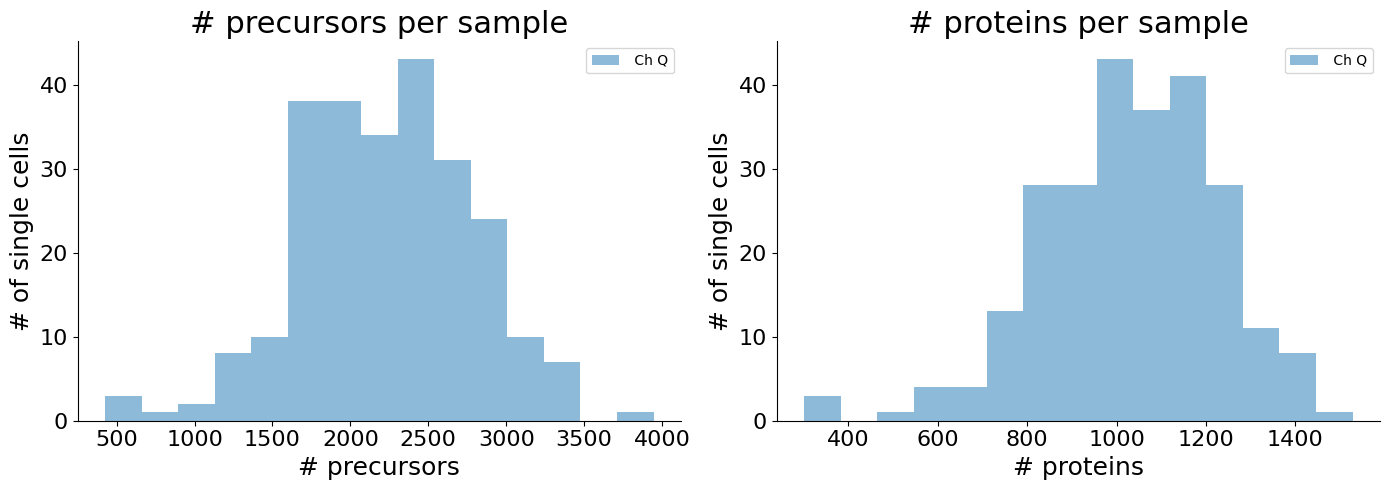

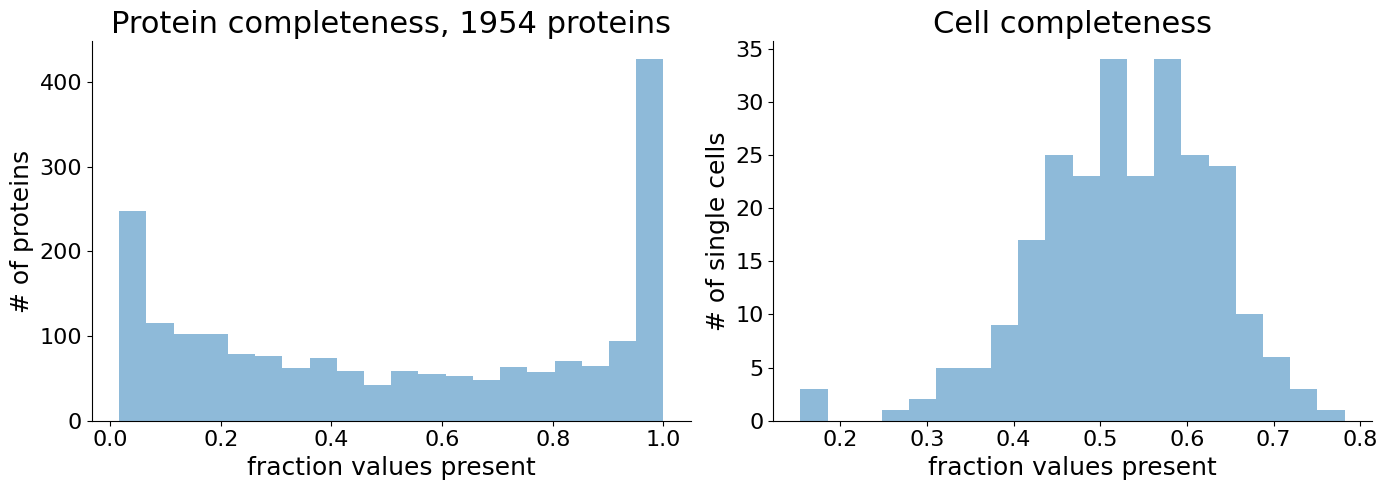

In [64]:
fig = qqc.plot_prot_and_pep(r1)
plt.show()

fig = qqc.plot_data_complete(r1)
plt.show()

---
## 11. Shared peptide correlations

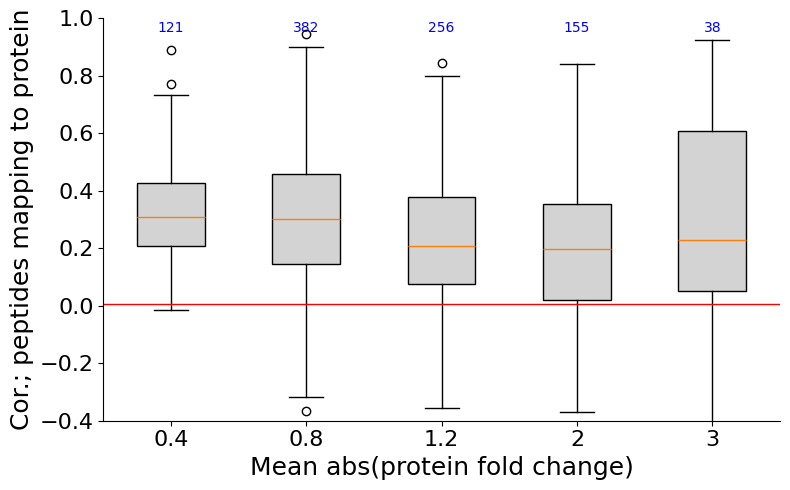

Median peptide correlation: 0.255


In [65]:
r1 = qqc.shared_peptide_cor(r1)

fig = qqc.plot_pep_cor(r1)
plt.show()

print(f'Median peptide correlation: {r1.pep_cor[0]["Cor"].median():.3f}')

---
## 12. KNN imputation

In [66]:
prot_df = mat_to_df(r1.matrices.protein, r1.matrices.protein_rows, r1.matrices.protein_cols)
prot_df.to_csv(os.path.join(data_out, 'Python_unnormalized_pipeline_protein.csv'))
print(f'Saved protein matrix: {prot_df.shape}')


r1 = qqc.knn_impute(r1)
print('KNN imputation complete.')

Saved protein matrix: (1954, 250)
KNN imputation complete.


---
## 13. Batch correction — mTRAQ label + sample

Mirrors R:
```r
limma::removeBatchEffect(protein.imputed, batch = label, batch2 = sample)
```

**Step 1** — label correction removes mTRAQ channel (0 / 4 / 8) bias.  
**Step 2** — sample-based normalization removes mouse-level (mouse1 vs mouse2) differences.

In [67]:
# Step 1: mTRAQ label correction (channel 0/4/8 bias)
r1 = qqc.batch_correct(r1, run=False, labels=True)

# Step 2: sample-based normalization (mouse1 vs mouse2)
# Mirrors batch2=sample in R's limma::removeBatchEffect
cols         = r1.matrices.protein_cols
meta_aligned = r1.meta_data[r1.meta_data['ID'].isin(cols)].set_index('ID').loc[cols]
na_mask      = np.isnan(r1.matrices.protein)

for s in meta_aligned['sample'].unique():
    idx         = (meta_aligned['sample'] == s).values
    batch_mean  = np.nanmean(r1.matrices.protein_imputed[:, idx], axis=1, keepdims=True)
    global_mean = np.nanmean(r1.matrices.protein_imputed,          axis=1, keepdims=True)
    r1.matrices.protein_imputed[:, idx] -= batch_mean - global_mean

r1.matrices.protein = r1.matrices.protein_imputed.copy()
r1.matrices.protein[na_mask] = np.nan

print('Batch correction (label + sample) complete.')

Batch correction (label + sample) complete.


---
## 14. Hemoglobin regression correction

For every protein: if R² vs hemoglobin (P01942) > 0.05, replace with
residuals re-centered to zero mean.

In [68]:
prot_df = mat_to_df(r1.matrices.protein, r1.matrices.protein_rows, r1.matrices.protein_cols)

hb_id = 'P01942'
if hb_id in prot_df.index:
    hb  = prot_df.loc[hb_id].values.astype(float)
    adj = prot_df.copy()

    for prot in prot_df.index:
        y  = prot_df.loc[prot].values.astype(float)
        ok = np.isfinite(y) & np.isfinite(hb)
        if ok.sum() < 3:
            continue

        X    = np.column_stack([np.ones(ok.sum()), hb[ok]])
        beta, _, _, _ = np.linalg.lstsq(X, y[ok], rcond=None)
        resid = y[ok] - X @ beta

        ss_res = np.sum(resid ** 2)
        ss_tot = np.sum((y[ok] - np.mean(y[ok])) ** 2)
        r2 = 1 - ss_res / ss_tot if ss_tot > 0 else 0

        if np.isfinite(r2) and r2 > 0.05:
            res_full = np.full(len(y), np.nan)
            res_full[ok] = resid + np.mean(y[ok])
            res_full[ok] = res_full[ok] - np.nanmean(res_full[ok])
            adj.loc[prot] = res_full

    r1.matrices.protein, _, _ = df_to_mat(adj)
    print(f'Hemoglobin correction applied ({hb_id}).')
else:
    print(f'{hb_id} not found — skipping.')

Hemoglobin correction applied (P01942).


---
## 15. PCA

In [69]:
r1 = qqc.compute_pca(r1, imputed=False)

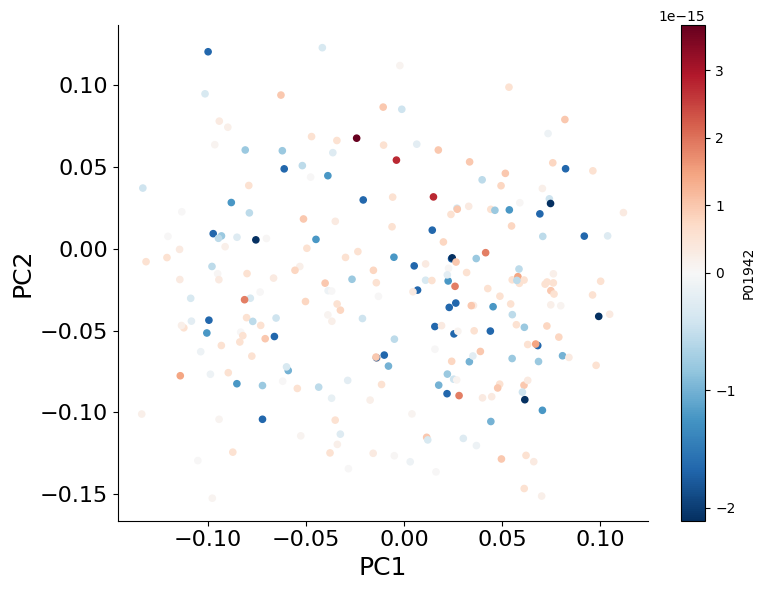

In [70]:
fig = qqc.feature_pca(r1, prot='P01942', imputed=False)  # Hemoglobin
plt.show()

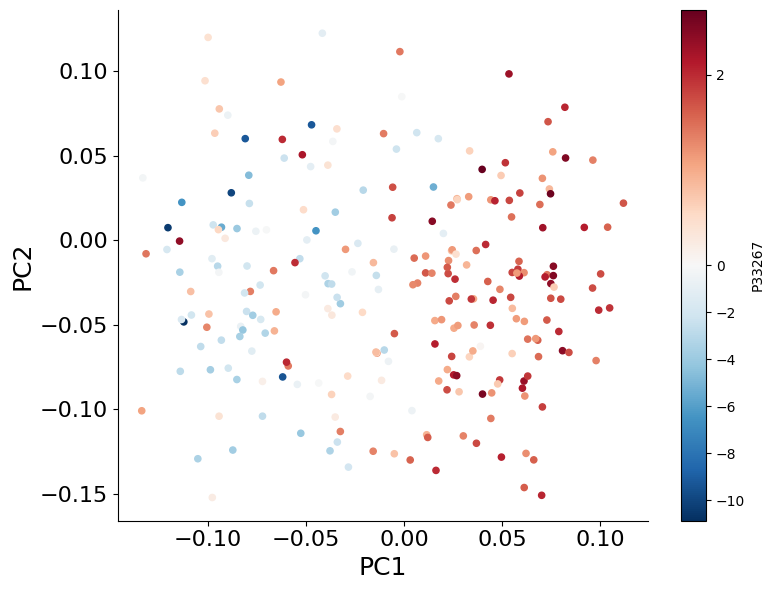

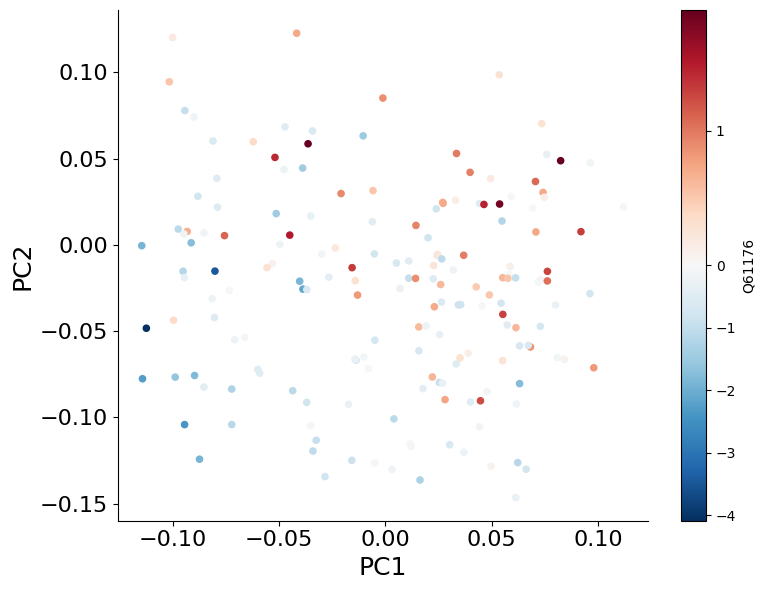

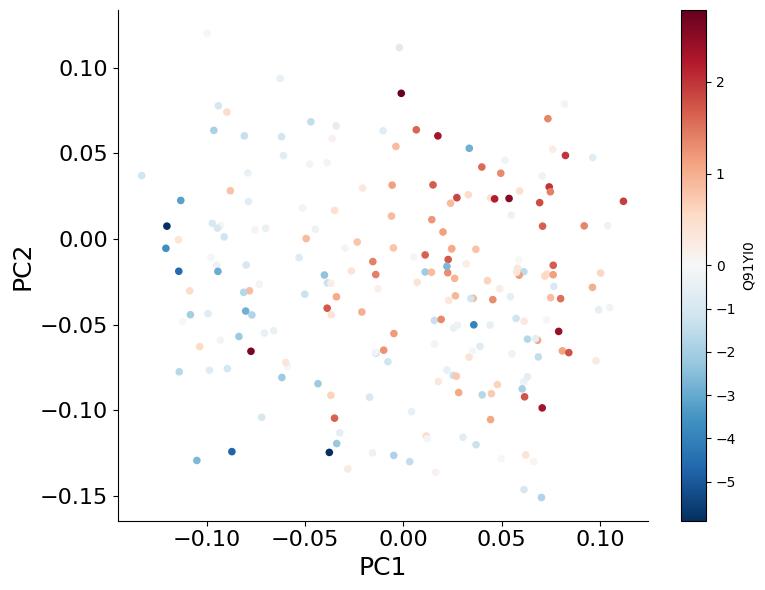

In [71]:
fig = qqc.feature_pca(r1, prot='P33267', imputed=False)  # Cyp2f2 (portal)
plt.show()

fig = qqc.feature_pca(r1, prot='Q61176', imputed=False)  # Arg1
plt.show()

fig = qqc.feature_pca(r1, prot='Q91YI0', imputed=False)  # Asl
plt.show()

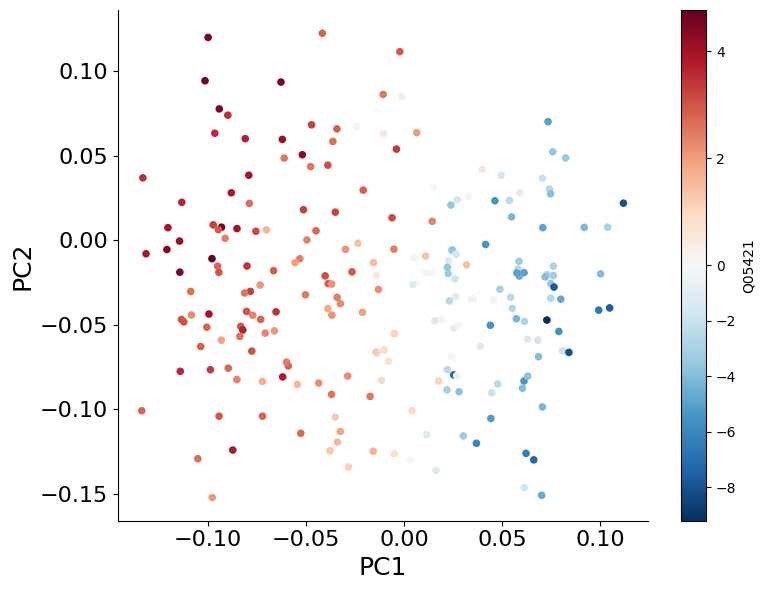

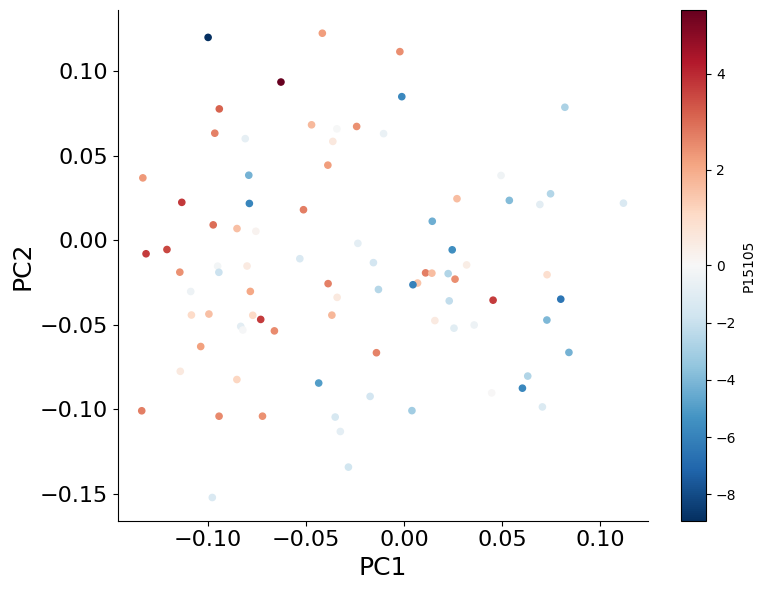

In [72]:
fig = qqc.feature_pca(r1, prot='Q05421', imputed=False)  # Cyp2e1 (central)
plt.show()

fig = qqc.feature_pca(r1, prot='P15105', imputed=False)  # Glul
plt.show()

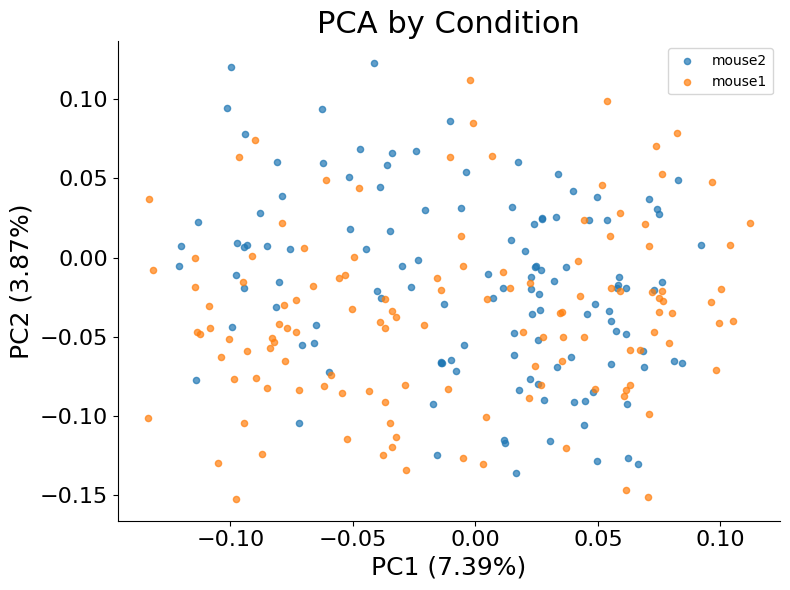

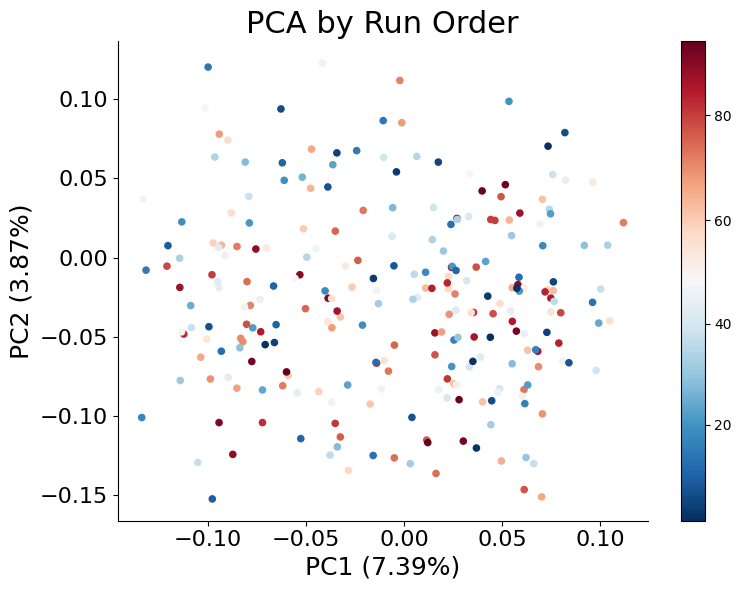

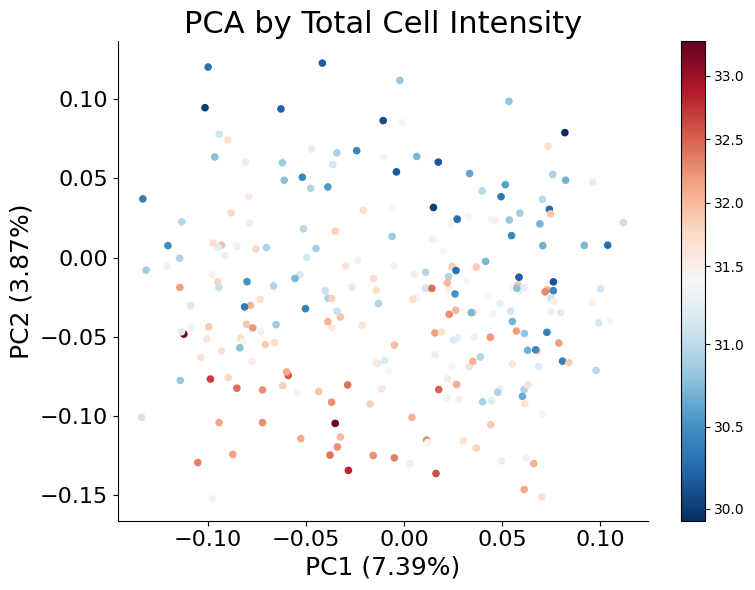

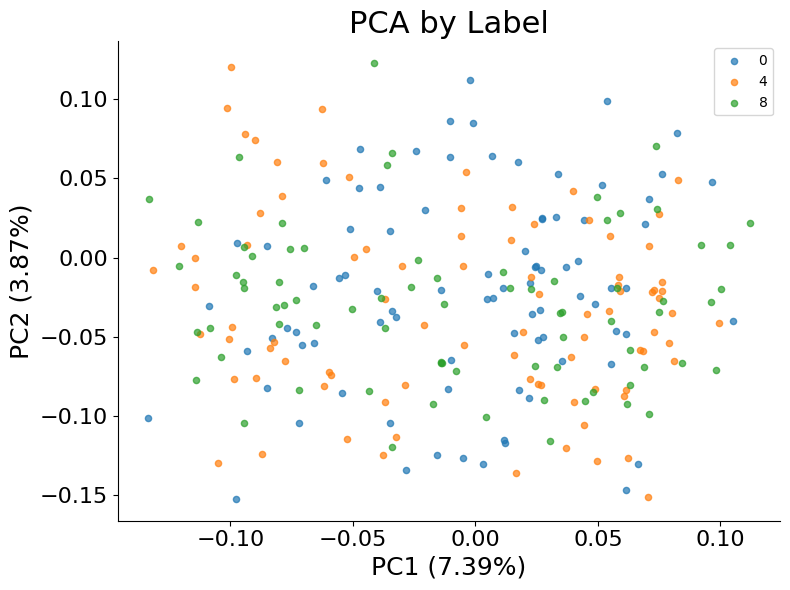

In [73]:
for by in ['Condition', 'Run order', 'Total protein', 'Label']:
    fig = qqc.plot_pca(r1, by=by)
    plt.show()

---
## 16. UMAP

In [74]:
r1 = qqc.compute_umap(r1)

/Users/andrewleduc/anaconda3/envs/scp/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


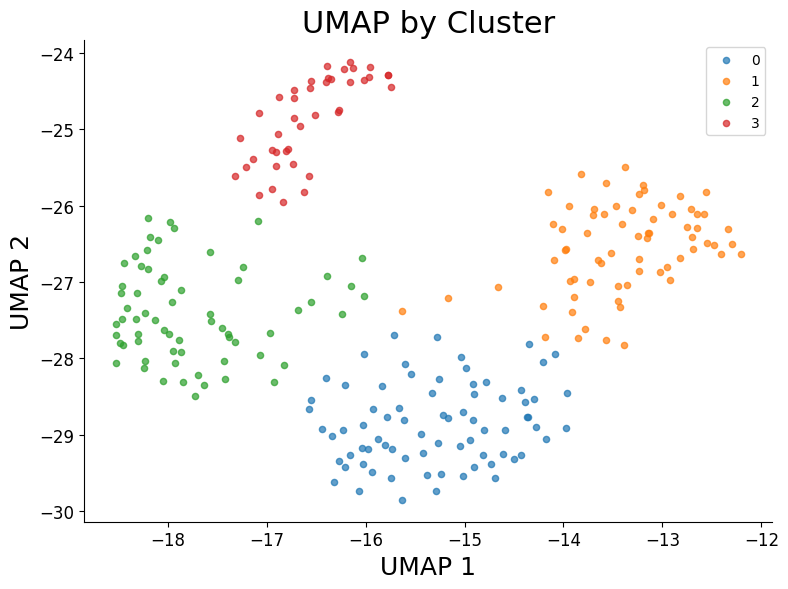

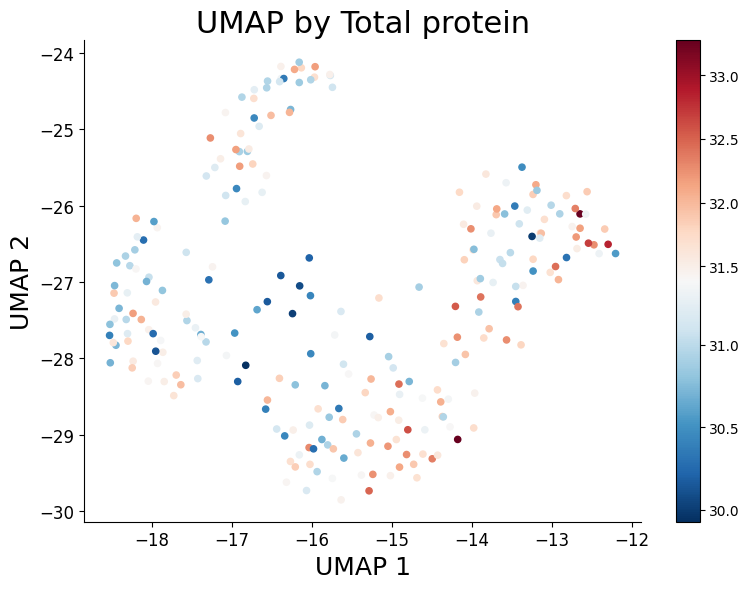

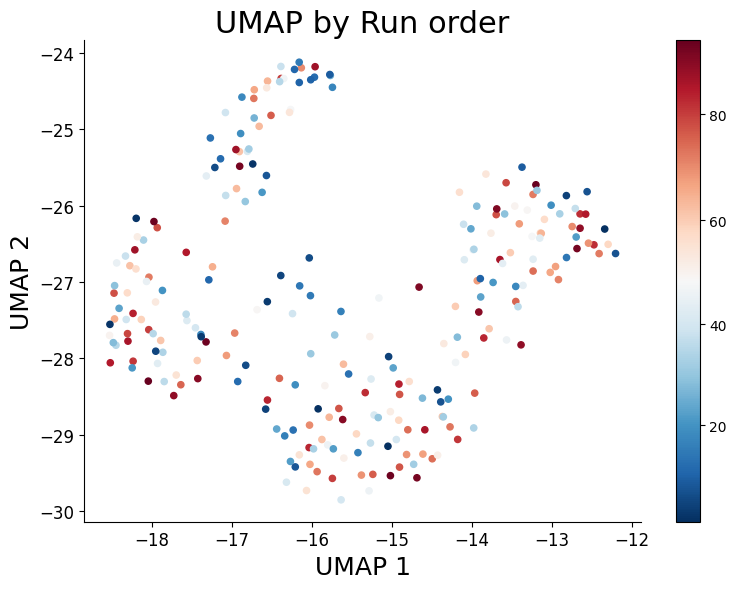

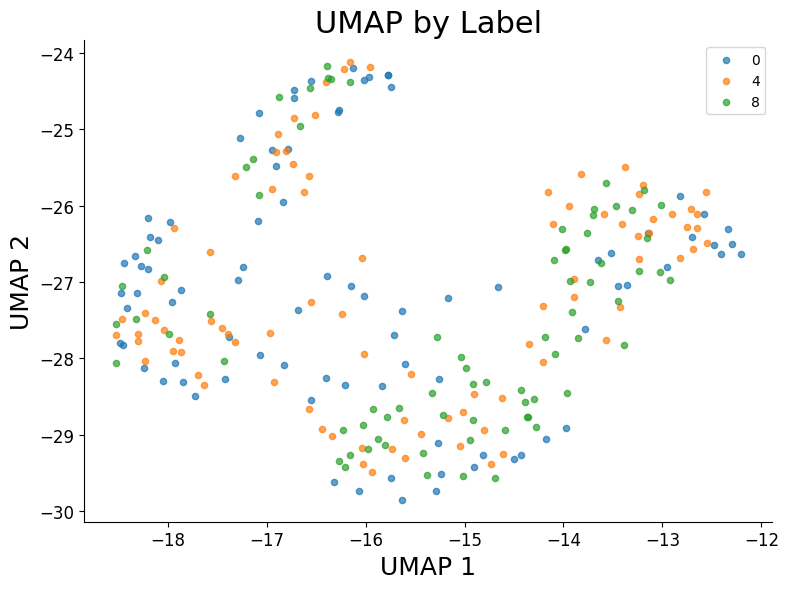

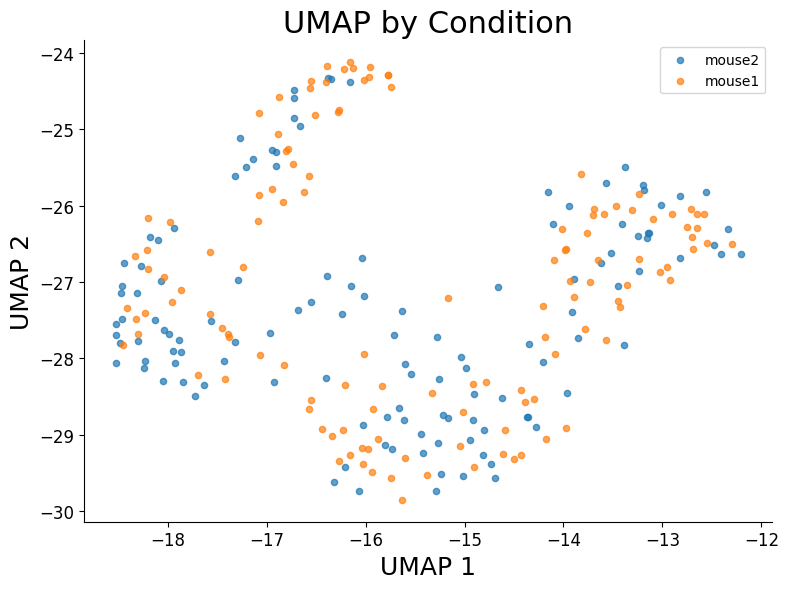

In [75]:
for by in ['Cluster', 'Total protein', 'Run order', 'Label', 'Condition']:
    fig = qqc.plot_umap(r1, by=by)
    plt.show()

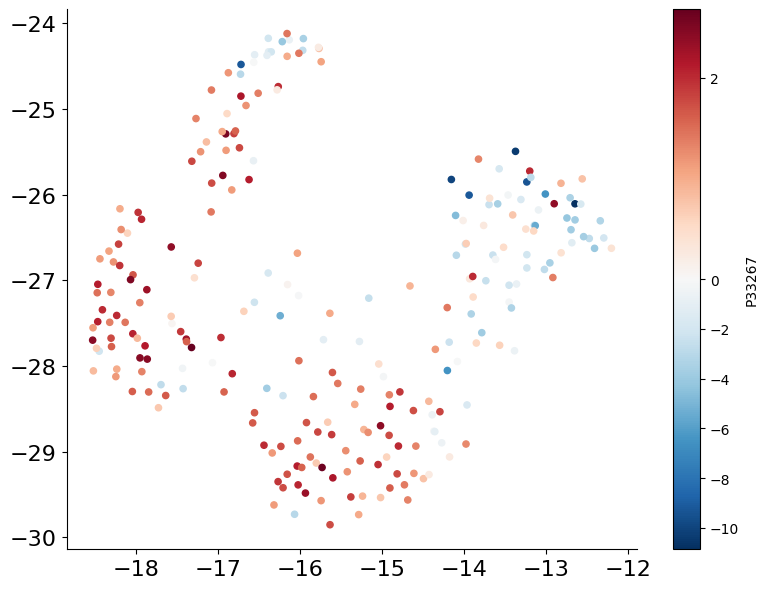

In [76]:
fig = qqc.feature_umap(r1, prot='P33267')  # Cyp2f2
plt.show()

---
## 17. Save outputs

In [77]:
prot_df = mat_to_df(r1.matrices.protein, r1.matrices.protein_rows, r1.matrices.protein_cols)
prot_df.to_csv(os.path.join(data_out, 'Python_pipeline_protein.csv'))
print(f'Saved protein matrix: {prot_df.shape}')

alpha_pep_df = mat_to_df(r1.miceotopes.Alpha_pep, r1.miceotopes.rows, r1.miceotopes.cols)
# Strip trailing '.0' from charge in row names to match R format (e.g. 'PEPTIDER3' not 'PEPTIDER3.0')
alpha_pep_df.index = alpha_pep_df.index.str.replace(r'\.0$', '', regex=True)
alpha_pep_df.to_csv(os.path.join(data_out, 'Python_pipeline_alpha_pep.csv'))
print(f'Saved alpha_pep matrix: {alpha_pep_df.shape}')

Saved protein matrix: (1954, 250)
Saved alpha_pep matrix: (6208, 250)


In [ ]:
import pickle
pkl_path = os.path.join(data_out, "r1_5day_male.pkl")
with open(pkl_path, "wb") as f:
    pickle.dump(r1, f)
print(f"Saved QQC object: {pkl_path}")